# Emojitranslate project

## Part one - learning to predict emojis from tweets

The following code adapted from the Osinga deep learning cookbook - using the Twitter API to sample EN language tweets that contain exactly one emoji

In [1]:
import random
import twitter
import emoji
# import itertools
import pandas as pd
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#from sklearn.model_selection import train_test_split
from keras import Sequential, optimizers, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
import keras.callbacks
#import json

import os
# import nb_utils
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Embedding, GlobalMaxPooling1D#, Merge 
from keras.models import Model
from keras.layers.merge import Concatenate, Average

# from gensim.models import Word2Vec

/home/nickdbn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
all_tweets = pd.read_csv('data/emojis_homemade.csv')
all_tweets['emoji'].value_counts()

😂        41754
😭        17086
❤        13562
emoji     9648
😍         9255
🔥         8833
🤣         5850
🤔         4561
🙏         4430
😩         4319
💕         4250
😊         4033
🖤         3961
👀         3664
✨         3450
💜         3447
👏         3361
🙄         3256
💀         3056
🎉         2918
🙌         2784
😏         2751
😘         2653
💯         2575
💙         2431
👍         2351
😔         2347
😎         2231
😉         2228
💖         2178
         ...  
🚉            1
🏣            1
⚱            1
🤵            1
👷            1
📒            1
🏨            1
🚛            1
🔚            1
🧘            1
🚈            1
👝            1
🀄            1
↕            1
🤼            1
🛥            1
🧚            1
💹            1
📤            1
🗜            1
🛋            1
➿            1
🧙            1
🚟            1
🕕            1
🛤            1
🗄            1
🔕            1
💇            1
🕍            1
Name: emoji, Length: 1065, dtype: int64

In [3]:
all_tweets.shape

(333642, 3)

In [4]:
all_tweets.head

<bound method NDFrame.head of         Unnamed: 0                                               text emoji
0              0.0  RT @mydear_bangtan: [VID] 181023 - Foi adicion...     ©
1              1.0  RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...     💫
2              2.0  RT @TrendsPrabhas: Now you are watching Indian...     😎
3              3.0                                    dats for keeps      💛
4              4.0  RT @xruiztru: WHO ARMS THE SAUDIS?\n\n  🇺🇸US 5...     🏳
5              5.0  RT @xxxfreaknasty2: interracial couple go at i...     🌝
6              6.0               @Eric_Deshaun Holy shit no I think.      😩
7              7.0     RT @fanmutuals: army, follow who retweet this      👑
8              8.0  RT @_Simplykpop: Simply K-Pop harddrive dump\n...     🤩
9              9.0  Happy birthday nellie @thelittlegend, hope you...     ❤
10            10.0  RT @montparnasty: "I have passed through fire"...     💕
11            11.0  RT @Jason_Mckeown: Look how empty Vall

In [5]:
tweets = all_tweets.groupby('emoji').filter(lambda c:len(c) > 1000)
tweets['emoji'].value_counts()

😂        41754
😭        17086
❤        13562
emoji     9648
😍         9255
🔥         8833
🤣         5850
🤔         4561
🙏         4430
😩         4319
💕         4250
😊         4033
🖤         3961
👀         3664
✨         3450
💜         3447
👏         3361
🙄         3256
💀         3056
🎉         2918
🙌         2784
😏         2751
😘         2653
💯         2575
💙         2431
👍         2351
😔         2347
😎         2231
😉         2228
💖         2178
         ...  
🙃         1683
🗣         1677
🤪         1632
😢         1576
😤         1549
☺         1486
🤗         1443
🤧         1428
©         1426
😒         1385
💥         1381
✌         1373
😌         1316
💗         1298
😫         1296
💔         1294
😈         1272
☹         1251
🙂         1242
👉         1232
🤝         1231
🎶         1217
🤩         1180
💚         1151
😆         1145
➡         1069
😋         1050
💞         1039
💓         1013
▶         1006
Name: emoji, Length: 72, dtype: int64

In [6]:
max(tweets['text'], key=lambda t:len(t))

'RT @DingDongLive: LMAO  @TexasEDMFamily\n@FreakyDeakyFam\nGrab my hard/hybrid trap mix&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt; https://t.co/34rcxAVbgk https://t.co/ArQeh23L…'

In [7]:
chars = list(sorted(set(chain(*tweets['text']))))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
max_sequence_len = max(len(x) for x in tweets['text'])

emojis = list(sorted(set(tweets['emoji'])))
emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
emojis[:10]

#train_tweets, test_tweets = train_test_split(tweets, test_size=0.1)

['emoji', '©', '‼', '▶', '☹', '☺', '♥', '✌', '✨', '❤']

Currently we've collected quite a lot of tweet data, so to speed up the prototyping of the model we're going to create a train/dev/test datasets of 10,000 tweets each.

In [8]:
train_tweets = tweets[0:10000]
dev_tweets = tweets[10000:20000]
test_tweets = tweets[20000:30000]

In [9]:
def data_generator(tweets, batch_size):
    while True:
        if batch_size is None:
            batch = tweets
            batch_size = batch.shape[0]
        else:
            batch = tweets.sample(batch_size)
        X = np.zeros((batch_size, max_sequence_len, len(chars)))
        y = np.zeros((batch_size,))
        for row_idx, (_, row) in enumerate(batch.iterrows()):
            y[row_idx] = emoji_to_idx[row['emoji']]
            for ch_idx, ch in enumerate(row['text']):
                X[row_idx, ch_idx, char_to_idx[ch]] = 1
        yield X, y

next(data_generator(tweets, 10))

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],


In [10]:
def create_char_cnn_model(num_chars, max_sequence_len, num_labels):
    char_input = Input(shape=(max_sequence_len, num_chars), name='char_cnn_input')
    
    conv_1x = Conv1D(128, 6, activation='relu', padding='valid')(char_input)
    max_pool_1x = MaxPooling1D(4)(conv_1x)
    conv_2x = Conv1D(256, 6, activation='relu', padding='valid')(max_pool_1x)
    max_pool_2x = MaxPooling1D(4)(conv_2x)

    flatten = Flatten()(max_pool_2x)
    dense = Dense(128, activation='relu')(flatten)
    preds = Dense(num_labels, activation='softmax', name='char_cnn_predictions')(dense)

    model = Model(char_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

char_cnn_model = create_char_cnn_model(len(char_to_idx), max_sequence_len, len(emojis))
char_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
char_cnn_input (InputLayer)  (None, 163, 2495)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 158, 128)          1916288   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 256)           196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
__________

In [11]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=2,
                              verbose=1, mode='auto')

checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_cnn.h5',
                                             monitor='val_acc',
                                             save_best_only = True)

#tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
#                                         histogram_freq=1,
#                                         embeddings_freq=1)

BATCH_SIZE = 512
char_cnn_model.fit_generator(
    data_generator(train_tweets, batch_size=BATCH_SIZE),
    validation_data = data_generator(dev_tweets, batch_size=BATCH_SIZE),
    validation_steps=int(dev_tweets.shape[0]/BATCH_SIZE),
    epochs=5,
    steps_per_epoch=len(train_tweets) / BATCH_SIZE,
    verbose=1, # was: verbose=2
    callbacks=[early, checkpoint]
)

Epoch 1/5


KeyboardInterrupt: 

In [ ]:
pd.options.display.max_colwidth = 128
inspect_tweets = dev_tweets.sample(100)
predicted = char_cnn_model.predict_generator(data_generator(inspect_tweets, batch_size=None), steps=1)
show = pd.DataFrame({
    'text': inspect_tweets['text'],
    'true': inspect_tweets['emoji'],
    'pred': [emojis[np.argmax(x)] for x in predicted],
})
show = show[['text', 'true', 'pred']]
show.head(10)

# Simple neural network - single Dense layer

Benchmark performance with the simplest neural network we can get

Let's divide up the train/dev/test sets so we're not relying on a generator

In [12]:
x_train = train_tweets["text"]
y_train = np.asarray(train_tweets["emoji"])
x_dev = dev_tweets["text"]
y_dev = np.asarray(dev_tweets["emoji"])
x_test = test_tweets["text"]
y_test = np.asarray(test_tweets["emoji"])

all_emojis = np.concatenate((y_train, y_dev, y_test), axis=0)

emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
#emojis[:10]

all_emojis_idx = np.zeros(all_emojis.shape[0])

for i in range (all_emojis.shape[0]):
    all_emojis_idx[i] = emoji_to_idx[all_emojis[i]]    

all_emojis_one_hot = to_categorical (all_emojis_idx)
    
y_train_idx = all_emojis_one_hot[0:10000,:]
y_dev_idx = all_emojis_one_hot[10000:20000,:]
y_test_idx = all_emojis_one_hot[20000:30000,:]

In [13]:
y_train_idx[0:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0

Now let's start by one-hot encoding the text samples

In [14]:
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts (x_train)

#x_train_sequences = tokenizer.texts_to_sequences(x_train)
#x_dev_sequences = tokenizer.texts_to_sequences(x_dev)
#x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_one_hot = tokenizer.texts_to_matrix(x_train, mode='binary')
x_dev_one_hot = tokenizer.texts_to_matrix(x_dev, mode='binary')
x_test_one_hot = tokenizer.texts_to_matrix(x_test, mode='binary')




# remember to pad sequences

In [15]:
x_train_one_hot.shape

(10000, 1000)

In [16]:
y_train_idx.shape

(10000, 72)

# A linear classifier

As a performance baseline for more complex models, it's instructive to see how well we can do with just a linear classifier with no hidden layer. With 64 hidden units trained on 10,000 training examples, we're able to get up to about 38% accuracy on the validation set. A lower learning rate slows down the learning (although it's still very fast) but doesn't appear to do any better in terms of final accuracy before the model starts overfitting. 

In [17]:
y_dev_idx.shape

(10000, 72)

In [18]:
output_size = y_dev_idx.shape[1] # around 64 units for 10,000 tweets

model = Sequential()
model.add(Dense(output_size, activation='softmax', input_shape=(1000,))) 
model.compile(optimizer=optimizers.RMSprop(lr = 0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    verbose=0)

In [19]:
import matplotlib.pyplot as plt

def plot_train_history(history): 

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot (epochs, acc, 'bo', label='Training acc')
    plt.plot (epochs, val_acc, 'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

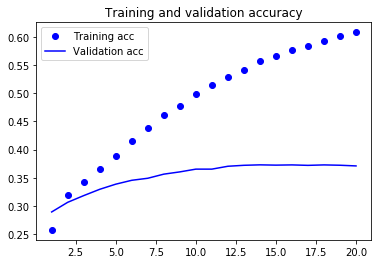

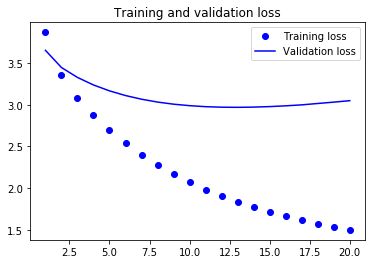

In [20]:
plot_train_history(history)

# Shallow neural network
A simple shallow neural network with a layer of hidden units

128 hidden units gets us up to 39% accuracy

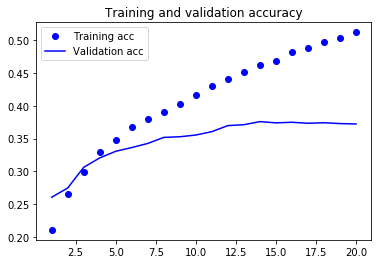

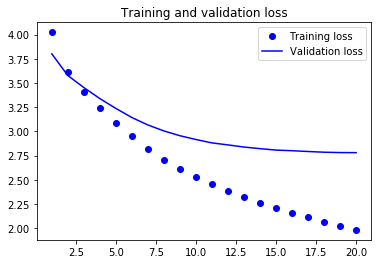

In [22]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(1000,)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    verbose=0,
                    validation_data = (x_dev_one_hot, y_dev_idx))

plot_train_history(history)

# Two layers of hidden units
A slight improvement over one layer of hidden units (<1%)

Train on 10000 samples, validate on 10000 samples
Epoch 1/60
 - 1s - loss: 4.1498 - acc: 0.1824 - val_loss: 3.8775 - val_acc: 0.2202
Epoch 2/60
 - 1s - loss: 3.6324 - acc: 0.2817 - val_loss: 3.6044 - val_acc: 0.3089
Epoch 3/60
 - 1s - loss: 3.3146 - acc: 0.3372 - val_loss: 3.3917 - val_acc: 0.3256
Epoch 4/60
 - 1s - loss: 3.0956 - acc: 0.3679 - val_loss: 3.2937 - val_acc: 0.3277
Epoch 5/60
 - 1s - loss: 2.9385 - acc: 0.3903 - val_loss: 3.2172 - val_acc: 0.3450
Epoch 6/60
 - 1s - loss: 2.8134 - acc: 0.4050 - val_loss: 3.1736 - val_acc: 0.3490
Epoch 7/60
 - 1s - loss: 2.7140 - acc: 0.4231 - val_loss: 3.1421 - val_acc: 0.3471
Epoch 8/60
 - 1s - loss: 2.6202 - acc: 0.4433 - val_loss: 3.0971 - val_acc: 0.3595
Epoch 9/60
 - 1s - loss: 2.5410 - acc: 0.4544 - val_loss: 3.0719 - val_acc: 0.3628
Epoch 10/60
 - 1s - loss: 2.4754 - acc: 0.4671 - val_loss: 3.0760 - val_acc: 0.3713
Epoch 11/60
 - 1s - loss: 2.4063 - acc: 0.4805 - val_loss: 3.0546 - val_acc: 0.3697
Epoch 12/60
 - 1s - loss: 2.3428 - 

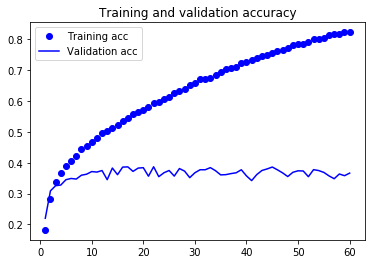

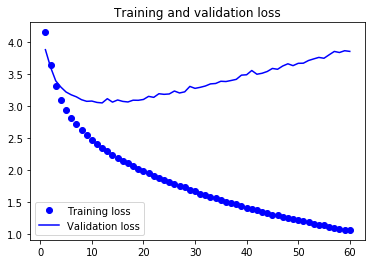

In [23]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(1000,)))
model.add(Dense(128, activation='relu', 
                kernel_regularizer = regularizers.l2(0.0025)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 60,
                    batch_size = 512,
                    verbose=2,
                    validation_data = (x_dev_one_hot, y_dev_idx))

plot_train_history(history)

In [ ]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(1000,)))
model.add(Dense(128, activation='relu',
                kernel_regularizer = regularizers.l2(lambd)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    verbose=2,
                    validation_data = (x_dev_one_hot, y_dev_idx))

plot_train_history(history)